# Landsat-8 True Colour Time Series via Sentinel-Hub Process API

### _Import functional dependencies and add repository source directory to system path_

In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'process'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\process'

In [3]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'landsat-8' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\process\\cfg\\landsat-8'

### _Load configuration file from repository cfg sub-directory_ 

In [4]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 'l8-timeseries-rgb.yml' )

In [5]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [{
                            bands: ["B02", "B03", "B04"],
                            units: ["reflectance", "reflectance", "reflectance"] 
                        }],
                        output: {
                            bands: 3,
                            sampleType: "FLOAT32"
                        }
                    };
                }
                function evaluatePixel(sample) {
                    return [sample.B04, sample.B03, sample.B02];
                }
    inputs:
        - collection: LANDSAT_OT_L2
responses:
    default: TIFF
aoi:
    pathname: <path-to-aoi-file>
    name: name
    distance: 500



In [6]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

### _Define area of interest centred on the Bristol Channel, UK_

In [7]:
# define min and max latlons
coords = -3.162415,51.154338,-2.365906,51.640874
resolution = 30

In [8]:
# create instance of shclient class
from processapi import Client
client = Client( config )

In [9]:
# redefine base url for nasa / usgs datasets
client._config.sh_base_url = 'https://services-uswest2.sentinel-hub.com'
client.getDataCollections()

[<DataCollection.SENTINEL2_L1C: DataCollectionDefinition(
   api_id: sentinel-2-l1c
   catalog_id: sentinel-2-l1c
   wfs_id: DSS1
   service_url: https://services.sentinel-hub.com
   collection_type: Sentinel-2
   sensor_type: MSI
   processing_level: L1C
   bands: (Band(name='B01', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B02', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B03', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B04', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B05', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B06', units=

In [10]:
# get utm bbox
bbox = client.getBoundingBox( coords )
print ( bbox, bbox.crs.value )

488641.2588534049,5667000.623443066,543878.1683775827,5721286.814773474 32630


In [11]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(1841, 1810)

### _Use Catalog API to locate available L8 scenes acquired during April - May 2021_

In [12]:
# define aggregation timeframe
from datetime import datetime
timeframe = { 'start' : datetime.strptime('2021-04-20', '%Y-%m-%d'), 'end' : datetime.strptime('2021-05-05', '%Y-%m-%d') }

In [13]:
# get scenes from catalogue
client.getDatasetTimeStamps( config.request.inputs[ 0 ], bbox, timeframe )

[datetime.datetime(2021, 4, 23, 11, 10, 33, 517000, tzinfo=tzutc()),
 datetime.datetime(2021, 4, 25, 10, 58, 10, 764000, tzinfo=tzutc()),
 datetime.datetime(2021, 5, 2, 11, 4, 17, 127000, tzinfo=tzutc())]

### _Download and visualise L8 True Colour Images via Process API client_

In [14]:
# get mosaic between timeframe at specified pixel resolution
response = client.getTimeSeries( bbox, timeframe, resolution )
response._df

default  \
0  [[[0.059985, 0.068785, 0.0431825], [0.0630375,...   
1  [[[nan, nan, nan], [nan, nan, nan], [nan, nan,...   
2  [[[0.06411, 0.092435, 0.059105], [0.079125, 0....   

                              time  
0 2021-04-23 11:10:33.517000+00:00  
1 2021-04-25 10:58:10.764000+00:00  
2 2021-05-02 11:04:17.127000+00:00

In [15]:
import numpy as np

# enhance image contrast by applying stretch and clip
factor=3.5/255
response._df[ 'default-vis' ] =  response._df[ 'default' ] * 2.5
response._df[ 'default-vis'] = response._df[ 'default-vis' ].apply( lambda x: np.clip( x, 0.0, 1.0 ) )

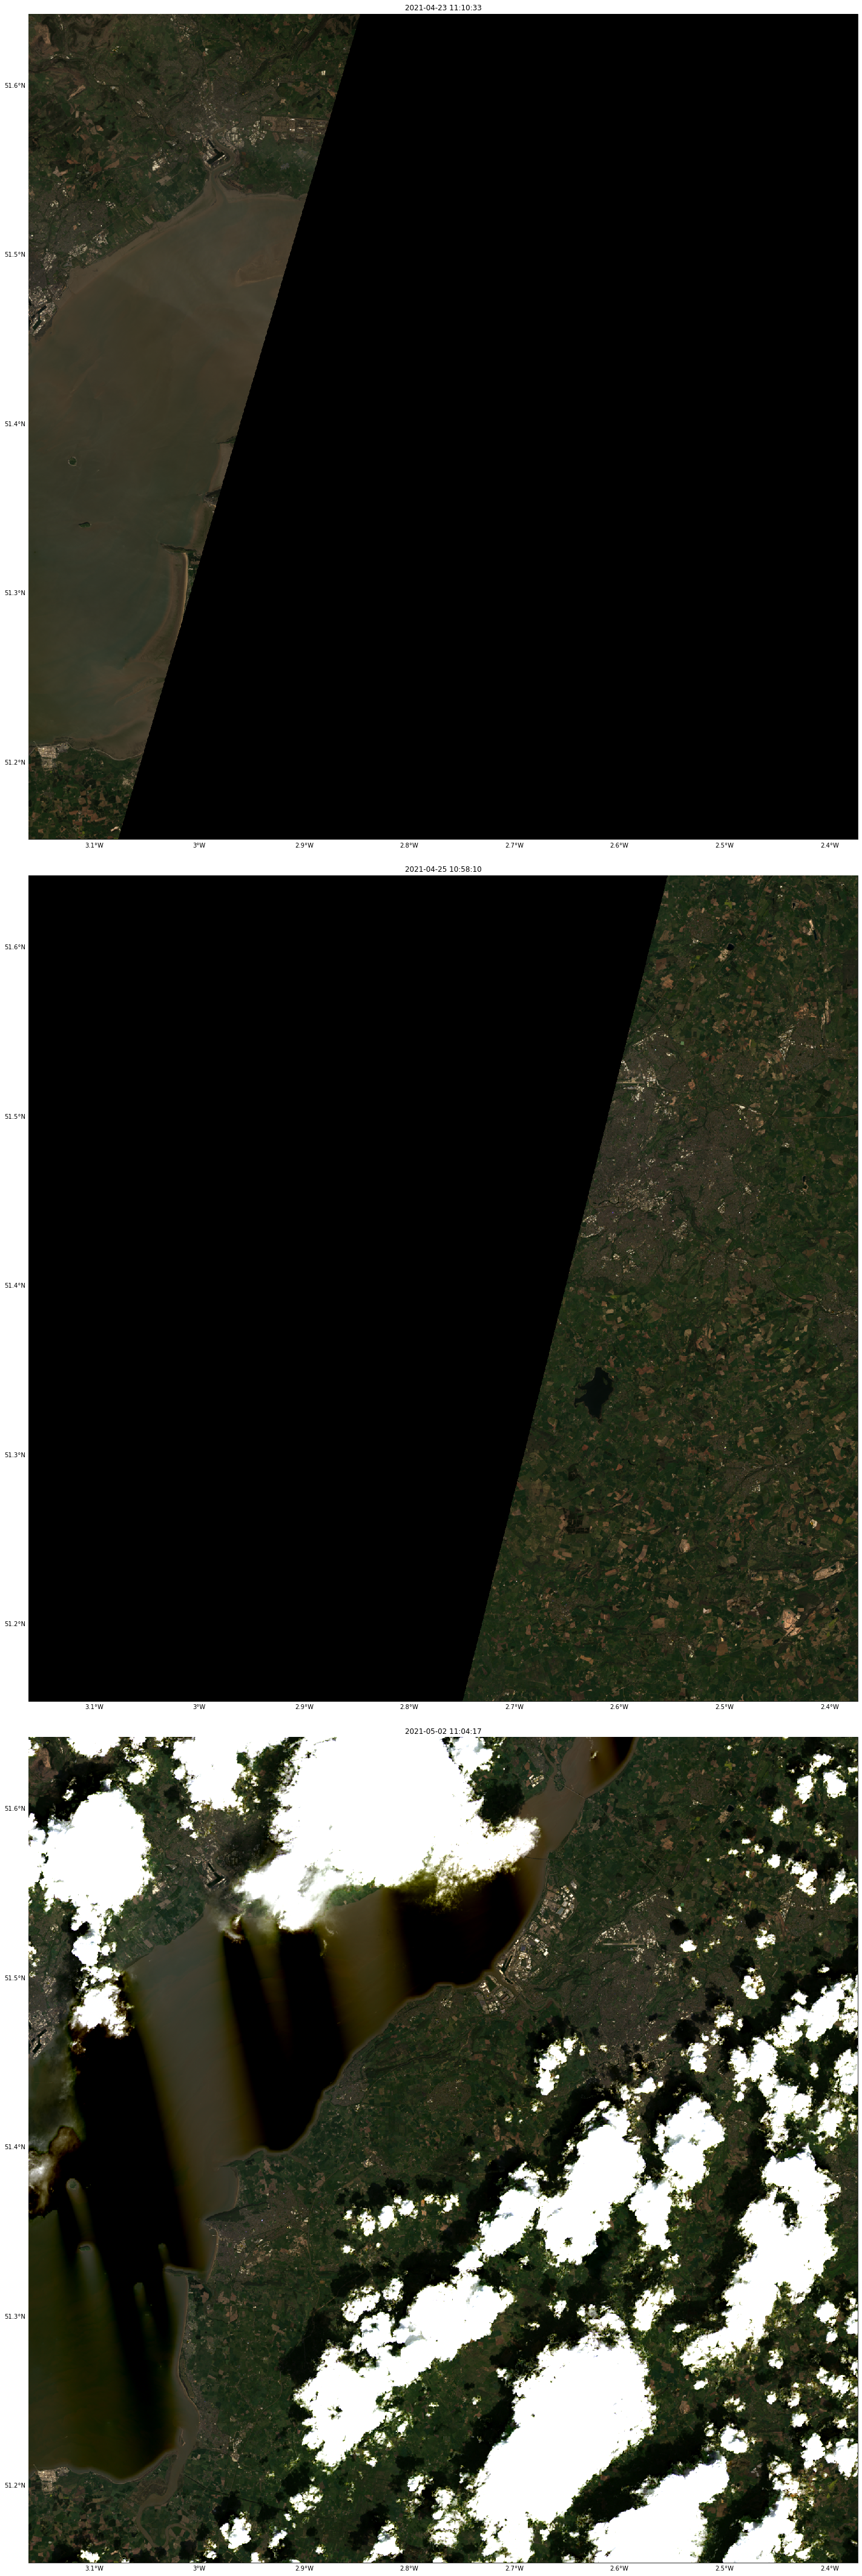

In [16]:
response.plotImages( 'default-vis', alpha={ 'data': 1.0, 'grid' : 0.0 } )